# Learning the ceritificate and partitioning

In [9]:
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as D
import torch.nn.functional as F 
import torch.optim as optim 
from sklearn.cluster import KMeans 
from sklearn.metrics import classification_report

from envs import Spiral
from learner import reach_nn

## Certificate

In [51]:
env  = Spiral(alpha=0.5, beta=0.5)
cert = reach_nn()  # Certificate NN.

In [52]:
# Tunable hyperparameters for learning: eps, lr, weight_decay
EPS_TGT, EPS_DEC = 1e-1, 1e-2

def loss_tgt(cert, x_tgt, eps_tgt=1e-1):
    N = len(x_tgt)
    return 1/N * torch.sum(
        torch.relu(cert(x_tgt) - eps_tgt) )


def loss_dec(cert, x_dec, eps_dec=1e-2):
    f = torch.vmap(env.f)
    x_nxt = f(x_dec)
    
    N = len(x_dec)
    return 1/N * torch.sum(
        torch.relu(cert(x_nxt) - cert(x_dec) + eps_dec) )


def loss_fn(cert, x_tgt, x_dec):
    return ( 1*loss_tgt(cert, x_tgt) 
            + 100*loss_dec(cert, x_dec) )


x = torch.rand(64000, 2)*2 - 1
tgt_mask = torch.logical_and(
    torch.abs(x[:,0]) <= 0.05,
    torch.abs(x[:,1]) <= 0.05, )
x_dec = x[~tgt_mask]
x_tgt = torch.rand(4000, 2)*0.1 - 0.05
print(f'|x_tgt|={len(x_tgt)}, |x_dec|={len(x_dec)}')


N_EPOCH, N_BATCH = 512, 40


def fit_cert():
    tgt_ld = D.DataLoader(x_tgt, batch_size= 50, shuffle=True)
    dec_ld = D.DataLoader(x_dec, batch_size=200, shuffle=True)
    
    optimizer = optim.Adam(
        cert.parameters(),
        lr=3e-3,
        weight_decay=1e-5
    )

    for e in range(N_EPOCH+1):
        epoch_loss = 0
        tgt_it, dec_it = iter(tgt_ld), iter(dec_ld)
        for b in range(N_BATCH):
            x_t, x_d = next(tgt_it), next(dec_it)
            optimizer.zero_grad()
            loss = loss_fn(cert, x_t, x_d)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
        if e % 64 == 0:
            print(f'{e:>3}. Epoch loss={epoch_loss:>10.6f}')

fit_cert()

|x_tgt|=4000, |x_dec|=63851
  0. Epoch loss= 55.077406
 64. Epoch loss=  0.006398
128. Epoch loss=  0.001608
192. Epoch loss=  0.000000
256. Epoch loss=  0.000002
320. Epoch loss=  0.000000
384. Epoch loss=  0.000000
448. Epoch loss=  0.000000
512. Epoch loss=  0.000000


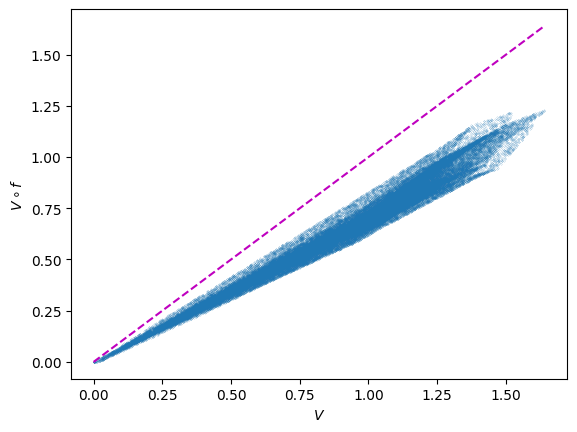

In [54]:
v = cert(x_dec)
vf = cert(torch.vmap(env.f)(x_dec))
assert torch.all(v > vf)

v =  cert(x)
vf = cert(torch.vmap(env.f)(x))
v, vf = v.detach(), vf.detach()

plt.plot(
    [torch.min(v), torch.max(v)], [torch.min(v), torch.max(v)], 'm--')
plt.scatter(v, vf, s=0.01)
plt.xlabel(r'$V$')
plt.ylabel(r'$V \circ f$')
plt.show()

# Partitioning

## Heuristic: Strengthened Decrease Condition

In [16]:
def partition(x, y):
    N = len(x)
    P = []
    
    for i in range(N):
        print(f'i={i}. P={P}')
        # idx is the lowest value where v(f(x[i])) < v[x[idx]]
        _, idx = binary_search(
            P, len(P), lambda p: y[i] >= p[0][0])
        print(f'  idx={idx}')
        if idx == len(P):
            P.append( [(x[i], y[i])] )
        else:
            P[idx].append( (x[i], y[i]) )
    return x, P

x = [2,   3, 4,   5,    6, 7]
y = [1, 1.5, 3, 1.75, 3.5, 5]

x, P = partition(x, y)
print(f'P={P}')

i=0. P=[]
  idx=0
i=1. P=[[(2, 1)]]
  idx=0
i=2. P=[[(2, 1), (3, 1.5)]]
  idx=1
i=3. P=[[(2, 1), (3, 1.5)], [(4, 3)]]
  idx=0
i=4. P=[[(2, 1), (3, 1.5), (5, 1.75)], [(4, 3)]]
  idx=1
i=5. P=[[(2, 1), (3, 1.5), (5, 1.75)], [(4, 3), (6, 3.5)]]
  idx=2
P=[[(2, 1), (3, 1.5), (5, 1.75)], [(4, 3), (6, 3.5)], [(7, 5)]]


In [43]:
def binary_search(a, n, f):
    """Binary search with a given condition f.
    
    Returns: 
      l: highest value for i where f[i] holds.
      r: lowest  value for i where f[i] does not hold.
    """
    l, r = -1, n
    while r-l > 1:
        m = (l+r) >> 1
        if f(a[m]):
            l = m
        else:
            r = m
    return l, r


def partition(x: torch.Tensor, v, f):
    # Assumption. The learned certificate does not violate the 
    # decrease condition on any of the states given in x.
    f_vmap = torch.vmap(f)
    assert torch.all(v(x) > v(f_vmap(x)))
    
    _, sort_idx = torch.sort(v(x), dim=0)
    # Sort x such that (i < j) <=> v(x[i]) < v(x[j])
    x = x[sort_idx]
    # Remove extra dimensions of size 1 that come from 
    # picking certain indices of x.
    # After this step, x should be a Nx2 matrix.
    x = torch.squeeze(x)
    
    # A list of all partitions.
    # For each partition p, p[0] is the _representative_ of p.
    # This property of the partitions enables us to use binary 
    # search when choosing an existing partition for a new point.
    P = []
    for i in range(len(x)):
        # idx is the first existing partition to which we can 
        # add x[i].
        _, idx = binary_search(
            P, len(P), lambda p: v(f(x[i])) >= v(p[0]))
        if idx == len(P): 
            # x[i] cannot be added to any of the existing partitions,
            # so we need to create its own partition.
            P.append( [x[i]] )
        else:
            P[idx].append(x[i])
    return x, P


_, P = partition(x_dec, cert, env.f)
print(f'|P|={len(P)}')

|P|=19


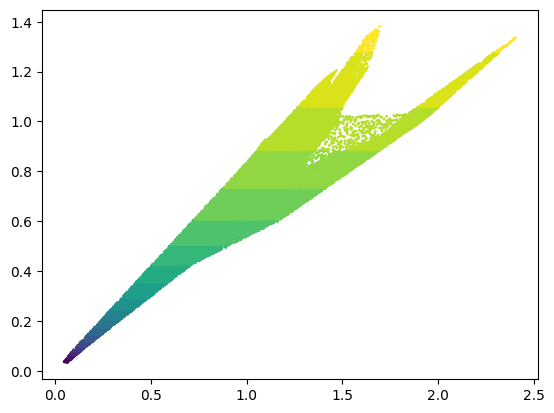

In [44]:
f_vec = torch.vmap(env.f)

x_dec1, v, vf, c = [], [], [], []
for i, p in enumerate(P):
    x_p = torch.vstack(p)
    x_dec1.append(x_p)
    v.append(cert(x_p).detach())
    vf.append(cert(f_vec(x_p)).detach())
    c.append(torch.ones(len(x_p))*i)

x_dec1 = torch.vstack(x_dec1)
v = torch.vstack(v)
vf = torch.vstack(vf)
c = torch.cat(c)

plt.scatter(v, vf, c=c, s=1)
plt.show()

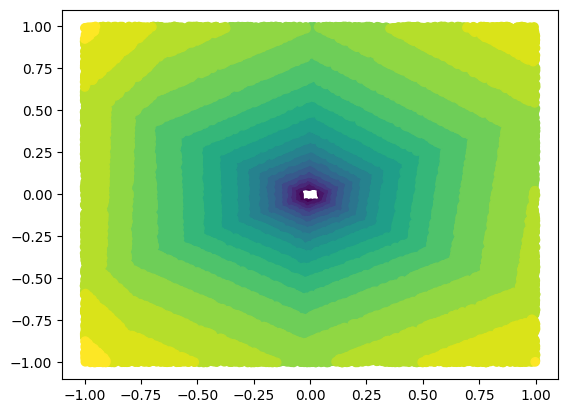

In [45]:
plt.scatter(x_dec1[:,0], x_dec1[:,1],c=c)
plt.show()

In [10]:
SZ_P = len(P)
part = nn.Sequential(
    nn.Linear(2, 2*SZ_P), nn.ReLU(),
    nn.Linear(2*SZ_P, SZ_P), nn.ReLU(),
)

ids, cnt = torch.unique(c, return_counts=True)
# Similar to sklearn.utils.class_weight.compute_class_weight
weight = len(x_dec1) / (SZ_P * cnt)
loss_fn = nn.CrossEntropyLoss(weight=weight)

optimizer = optim.Adam(part.parameters(), lr=1e-3, weight_decay=1e-5)

N_EPOCH, BATSZ = 1024, 100
N_BATCH = len(x_dec1) // BATSZ
print(f'BATSZ={BATSZ}')
c = c.long()
dataset = D.TensorDataset(x_dec1, c)
bat_ld = D.DataLoader(
    dataset, 
    batch_size=BATSZ, 
    shuffle=True)

for e in range(N_EPOCH+1):
    epoch_loss = 0
    bat_it = iter(bat_ld)
    for b in range(N_BATCH):
        optimizer.zero_grad()
        nxt_bat = next(bat_it)
        x_d, y = nxt_bat
        loss = loss_fn(part(x_d), y)
        epoch_loss += loss.data
        loss.backward()
        optimizer.step()
        
    if e % 128 == 0:
        print(f'{e:>4}. Loss={epoch_loss:>16.6f}')

BATSZ=100
   0. Loss=     1983.477417
 128. Loss=     1340.282104
 256. Loss=     1079.547729
 384. Loss=      854.875488
 512. Loss=      745.856567
 640. Loss=      698.076538
 768. Loss=      666.673401
 896. Loss=      558.270386
1024. Loss=      445.877319


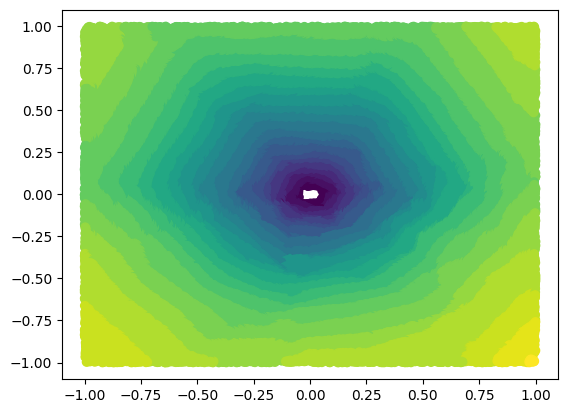

In [11]:
c_part = torch.argmax(part(x_dec1), dim=1)
plt.scatter(x_dec1[:,0], x_dec1[:,1], c=c_part)
plt.show()

In [12]:
print(classification_report(c, c_part))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        81
           1       0.54      0.66      0.60       167
           2       0.67      0.82      0.74       264
           3       0.75      0.76      0.75       274
           4       0.74      0.81      0.77       389
           5       0.72      0.79      0.75       585
           6       0.85      0.59      0.70       683
           7       0.77      0.77      0.77       772
           8       0.65      0.93      0.76       978
           9       0.91      0.52      0.66      1137
          10       0.77      0.84      0.80      1384
          11       0.74      0.86      0.80      1857
          12       0.82      0.73      0.77      1869
          13       0.87      0.73      0.79      2122
          14       0.67      0.85      0.75      2523
          15       0.85      0.60      0.70      3142
          16       0.71      0.92      0.80      3161
          17       0.85    

/Users/mahyar/anaconda3/envs/prototype/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mahyar/anaconda3/envs/prototype/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mahyar/anaconda3/envs/prototype/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

## Heuristic: $U(\mathbf{x}) = V(\mathbf{x}) - V(f(\mathbf{x}))$, Clustering

In [183]:
def knee(crv: torch.Tensor):
    """Knee point of a 2D-curve [(x1, y1), ..., (xn, yn)].
    
    We define the knee point of this curve as the point (xi, yi)
    which is the point farthest away from the line connecting 
    (x1, y1) and (xn, yn) (i.e., the line that connects the first 
    and last points in the curve).
    """
    assert len(crv.shape) == 2 and crv.shape[1] == 2
    
    # h = 2A / b
    b = (crv[0] - crv[-1]).square().sum().sqrt()
    # print(f'b={b}')

    x1, y1 = crv[0]
    xn, yn = crv[-1]
    idx_knee, h_knee = 0, 0.0
    for i, (xi, yi) in enumerate(crv):
        h = torch.abs((xn - x1)*(y1 - yi) - (yn - y1)*(x1 - xi)) / b
        # print(f'i={i:>2}, h[{i}]={h:>8.6f}')
        if h < h_knee:
            continue
        idx_knee, h_knee = i, h
    return idx_knee


curve = torch.Tensor([
    [0, 0],
    [1, 1],
    [2, 3],
    [3, 2],
    [4, 1],
    [5, 0],
])

assert knee(curve) == 2

Knee. k=8


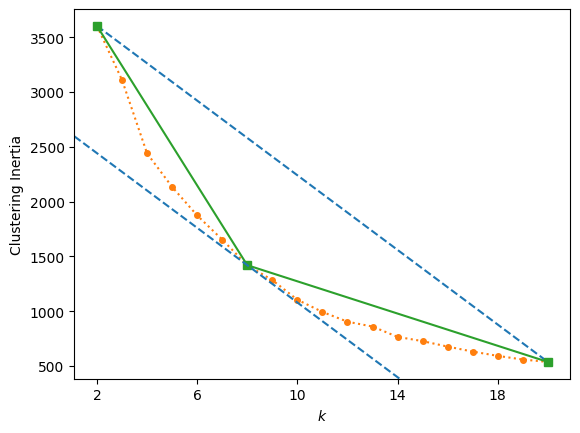

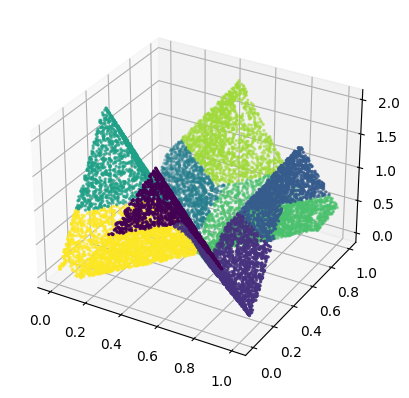

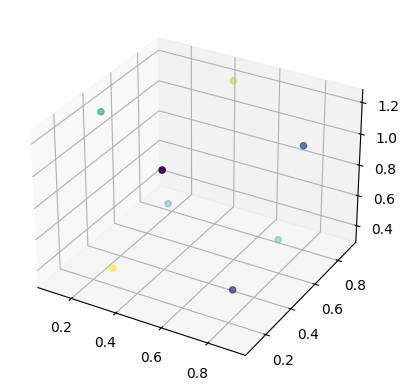

In [236]:
f_vec = torch.vmap(env.f)
dec = cert(x) - cert(f_vec(x))
p = torch.hstack(
    (x, dec.detach())
)

# Dimension normalization 
p_min, p_max = p.min(dim=0).values, p.max(dim=0).values
p = (p - p_min) / (p_max - p_min)
p[:, -1] *= 2
# p[:, -1] += 1000

curve = []
for k in range(2,20+1):
    kmeans = KMeans(n_clusters=k, n_init='auto').fit(p)
    curve.append( (k, kmeans.inertia_) )
curve = torch.Tensor(curve)

k = knee(curve)
print(f'Knee. k={2+k}')

plt.figure()
x1, y1 = curve[0]
xn, yn = curve[-1]
plt.plot([x1, xn], [y1, yn], '--')
plt.plot(curve[:,0], curve[:,1], ':o', markersize=4)
xk, yk = curve[k]
plt.plot([x1, xk, xn], [y1, yk, yn], '-s')
plt.xticks(range(2,21,4))
plt.axline((xk, yk), slope=(y1-yn)/(x1-xn), linestyle='dashed')
plt.xlabel(r'$k$')
plt.ylabel('Clustering Inertia')

kmeans = KMeans(n_clusters=2+k, n_init='auto').fit(p)
# p[:,-1] /= 2
## p[:,-1] -= 1000
# p = p * (p_max - p_min) + p_min
cs = kmeans.cluster_centers_

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(p[:,0], p[:,1], p[:,2], c=kmeans.labels_, s=2)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(cs[:,0], cs[:,1], cs[:,2], c=range(2+k))
plt.show()

# Verification

## Using Z3

In [ ]:
from z3 import *


# All the functions defined in this cell are re-definitions of 
# existing functions, but re-defined so that they can be used 
# in combination with an SMT solver (e.g., Z3).

def ReLU(x): return If(x >= 0 , x, 0)
def Abs (x): return If(x >= 0, x, -x)


def V(x):
    ReLU_ = np.vectorize(ReLU)
    y1 = w1 @ x + b1
    z1 = ReLU_(y1)
    y2 = w2 @ z1 + b2
    z2 = ReLU_(y2)
    y3 = w3 @ z2 + b3
    z3 = ReLU_(y3)
    return y3


def F(x):
    a, b = env.alpha, env.beta
    A = np.array( [
      [ a,  b], 
      [-b,  a]
    ] )
    return A @ x

x = np.array(RealVector('x', 2))
w1, w2, w3 = [
    cert.layers[i].weight.data.numpy() for i in range(3)]
b1, b2, b3 = [
    cert.layers[i].  bias.data.numpy() for i in range(3)]
v, vf = Real('v'), Real('vf')


def cex(C):
    """List of counter-examples to C.
    
    Args:
      C: A list of Z3 constraints.
    """
    s = Solver()
    s.add(C)
    chk = s.check()
    print(f'CEX. chk={chk}')
    if chk == sat:
        return s.model()
    elif chk == unsat:
        return None
    else:
        assert False, 'unknown result for SMT query'


def chk_dec():
    """Verification task for the Decrease condition."""
    print('CHK_DEC. Setting up the problem ...')
    domain = []
    domain += [Abs(x[i]) >= 0.05 for i in range(2)]
    domain += [Abs(x[i]) <= 1.00 for i in range(2)]
    
    problem = []
    V_x = V(x)
    VF_x = V(F(x))
    problem.append(v  == V_x [0])
    problem.append(vf == VF_x[0])
    problem.append(v - vf < EPS_DEC)

    return cex(domain + problem)


def chk_tgt():
    """Verification task for the Target condition."""
    print('CHK_TGT. Setting up the problem ...')
    domain = [Abs(x[i]) <= 0.05 for i in range(2)]
    problem = []
    V_x = V(x)
    problem.append(v == V_x[0])
    problem.append(v  > EPS_TGT)
    
    return cex(domain + problem)
    

cex_dec = chk_dec()
cex_tgt = chk_tgt()

print(cex_dec, cex_tgt)

In [ ]:
print ( [ float(cex_dec[x[i]].as_fraction()) for i in range(2)] )
print ( [ float(cex_tgt[x[i]].as_fraction()) for i in range(2)] )

In [116]:
from pysmt.shortcuts import Symbol, And, Ite, GE, Real, Times
from pysmt.typing import REAL


def Abs(x):
    iff = GE(x, Real(0))
    left = x 
    right = Times([Real(-1), x])
    return Ite(iff, left, right)


x = np.array([Symbol(f'x{i}', REAL) for i in range(2)])
domains = [GE(Abs(x[i]), Real(0.05)) for i in range(2)]
domains = And(domains)